# Insights into perturbations

In this final chapter of the tutorial we turn our attention to the perturbations in the grasslands dataset. The critical idea is that the proportion of mismatches between two community properties is equal to the collinearity of the community properties (i.e., the angle between their directions in state-space) ***only*** when perturbations have random effects. However, if perturbations don't have random effects, we can use mismatch data to uncover interesting features of their species-level effects.

As a reminder, the perturbations in the grassland dataset are: Warming (W), carbon dioxide enrichment (eCO2), decreased precipitation (PPT-), increased precipitation (PPT+), phosphorous addition (P), nitrogen addition (N), land-use change (LUC), W×eCO2, N×PPT+, N plus P plus potassium addition (N×P×K)). Land-use change can be subdivided into: land-use change types (NEtoAgr, conversion from native ecosystem to agriculture; NEtoPas, conversion from native ecosystem to pasture; NEtoPlant, conversion from native ecosystem to plantation; NEtoSec, conversion from native ecosystem to secondary ecosystem). Presumably a perturbation like warming will have a different sort of structure compared to a perturbation like land-use change?

In [1]:
import pandas as pd                  # general data organisation         
import numpy as np                   # general work with matrices and vectors 
import matplotlib.pyplot as plt      # general plotting work
import networkx as nx                # for plotting a network
import matplotlib.colors as mcolors  # for color gradients

# for text formating in figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",  
})

# loading the data and saving a colour
grasslands = pd.read_csv("data/grasslands.csv", index_col="Observation")
grass_col = '#b89247'

## Response diversity

We'll first estimate the *response diversity* of perturbations by comparing perturbations based on the proportion of mismatches in the observations of the same two functions. Let's take two broad functions, total biomass and respiration, whose responses are both reported for a high number of perturbations in the grasslands dataset. 

Compared to other pairs of functions, these two broad functions should have a realtively low proportion of mismatches across random perturbations. However, if perturbations have low response diversity (i.e., most species respond in the same direction), then perturbations will be bias in their directions in state-space towards the fully neagitve or fully positive areas of state-space (bottom left quadrant or top right quadrant of the figure below respectively). These two areas happen to completely avoid the cone of mismatches for functions that have positive directions. 

:::{figure-md} markdown-fig
<img src="images/cone-mismatches.png" alt="mismatches" class="bg-primary mb-1" width="50%">

If a perturbation falls in one of the red cones there will be a mismatch in the observations of the two functions.
:::

```{eval-rst}
.. note::

   These geometric arguments still work for communities with more than 2 species. It is just harder to visualize a one-hundred dimensional cone of mismatches!

.. include:: ./include-rst.rst
```


To summarise, the lower the response diversity of a perturbation, the lower the proportion of mismatches. Now let's use the proportion of mismatches between microbial biomass and respiration for each perturbation type in the grasslands dataset to estimate their response diversities.

In [2]:
# general organising
grass_RD = (grasslands[['MicrobialBiomass', 'Respiration', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'Respiration'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['Respiration']), 0, 1)))

# LUC can be subdivided
grass_RD['GC'] = np.where(grass_RD['GC'] == 'LUC', grass_RD['LUC'], grass_RD['GC'])

# Must have at least 5 observations
grass_RD = (grass_RD.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

# get proportion of mismatches
counts = grass_RD['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(grass_RD['GC'], grass_RD['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

# some messing around to get into a nice format
grass_RD = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='grasslands')
              .drop(['index'], axis=1))
grass_RD = grass_RD.rename(columns={grass_RD.columns[1]: 'Agree'})
grass_RD = grass_RD.rename(columns={grass_RD.columns[2]: 'Mismatches'})
grass_RD = grass_RD.rename(columns={grass_RD.columns[3]: 'N'})

# to avoid annoying Latex bugs 
grass_RD['GC'] = grass_RD['GC'].replace('N_P', 'N and P')

# set order from low to high response diversity 
# sort the order from highest to lowest broadness 
order = ["NEtoSec", "N", "eCO2", "N and P", "W"]
RD_data = grass_RD.copy()
RD_data['GC'] = pd.Categorical(RD_data['GC'], categories=order, ordered=True)
RD_data = RD_data.sort_values(by='GC')
RD_data = RD_data.reset_index(drop=True)


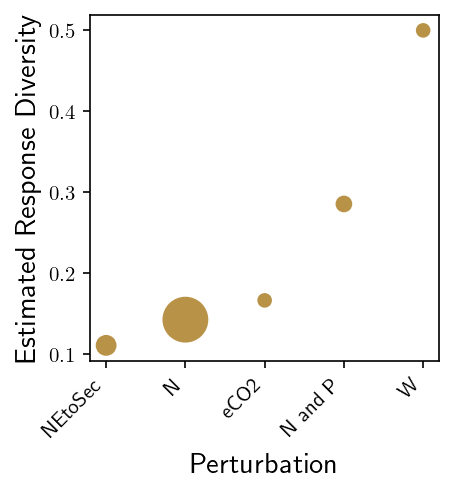

In [3]:
plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(RD_data['GC'], RD_data['Mismatches'],
        s = RD_data['N']**2, c = grass_col)
plt.title('', fontsize = 14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Perturbation', labelpad=5, fontsize = 14)
plt.ylabel('Estimated Response Diversity', fontsize = 14)
plt.show()

Five perturbation types had enough observations in the data set where the responses of both microbial biomass and microbial respiration were recorded to make reasonable estimates for response diversity. These were land-use change (conversion from native ecosystem to secondary ecosystem), nitrogen addition, carbon dioxide enrichment, nitrogen and phosphorus addition and warming. 

At opposite ends of the scale, land-use change had a very low response diversity while warming had a very high response diversity. This result are intuitive, given that warming often benefits some microbes but negatively impacts others, while land-use change would be expected to impact all species in the same way (presumably negatively as they will be replaced by microbes better suited to the new ecosystem type). You could think of warming often falling in the same direction as the red cone of mismatches in the figure above, but land-use change nearly always falling along the 1:1 line. 

## Biomass scaling

The second aspect of a perturbation's structure that we can quantify using mismatch data is how it's species-level effects scale with biomass. In other words, are species-level effects independent of biomass or do more abundant species have larger absolute changes in their biomass following a perturbation? 

Comparing mismatches between function and diversity is the critical step here. If a perturbation causes the biomass of abundant species to decrease, total biomass will decrease but diversity will increase. If on the other hand, a perturbation causes the biomass of abundant species to increase, total biomass will increase but diversity will decrease. As such, when perturbations are scaled by biomass, there will be higher proportion of mismatches between functiona and diversity.

Here, we'll compare the mimsmatches between biomass and the Shannon diversity index for each perturbation type to estimate their biomass scaling. Relatlively higher proportions of mismatches means relatively higher scaling by biomass.

In [4]:
grass_BS = (grasslands[['MicrobialBiomass', 'Shannon', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'Shannon'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['Shannon']), 0, 1)))

grass_BS['GC'] = np.where(grass_BS['GC'] == 'LUC', grass_BS['LUC'], grass_BS['GC'])

grass_BS = (grass_BS.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

counts = grass_BS['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(grass_BS['GC'], grass_BS['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

grass_BS = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='grasslands')
              .drop(['index'], axis=1))
grass_BS = grass_BS.rename(columns={grass_BS.columns[1]: 'Agree'})
grass_BS = grass_BS.rename(columns={grass_BS.columns[2]: 'Mismatches'})
grass_BS = grass_BS.rename(columns={grass_BS.columns[3]: 'N'})

grass_BS['GC'] = grass_BS['GC'].replace('N_PPT+', 'N and PPT')

order = ["W", "P", "N", "N and PPT", "NEtoSec", "NEtoAgr", "NEtoPas"]
BS_data = grass_BS.copy()
BS_data['GC'] = pd.Categorical(BS_data['GC'], categories=order, ordered=True)
BS_data = BS_data.sort_values(by='GC')
BS_data = BS_data.reset_index(drop=True)

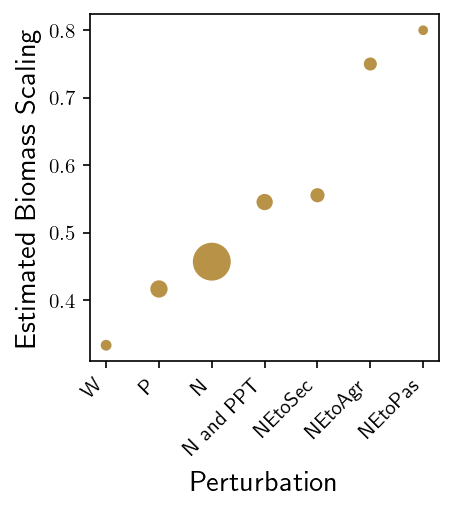

In [5]:
plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(BS_data['GC'], BS_data['Mismatches'],
        s = BS_data['N']**1.6, c = grass_col)
plt.title('', fontsize = 14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Perturbation', labelpad=5, fontsize = 14)
plt.ylabel('Estimated Biomass Scaling', fontsize = 14)
plt.show()

Seven perturbation types had enough observations in the data set where the responses of both microbial biomass and Shannon diversity were recorded to make reasonable estimates for biomass scaling: wawrming, phosphours addition, nitrogen addition, phosphrous and increased precipitation, and three categories of land-use change. 

The most striking result here is that the three perturbation types describing different types of land-use change all had the highest biomass scaling. This suggests that land-use change has proportional impacts on species abundances. For example, you could think of a land-use perturbation removing for example 50% of all poulations, so a population with 100 individuals would go to 50 and a population with 20 individuals would go to 10. On the other hand, warming and nutrient perturbations had lower biomass scaling, suggesting that the relative magnitude of perturbations varied across species. 

## Final thoughts

Taken together, we can gain considerable insights into the structure of perturbations from the patterns of mismatches in the observations of community properties. Using just the responses of microbial biomass, microbial respiration, and Shannon diversity, we were able to quantify how perturbations of land-use change impact all species in very similar ways both in terms of the direction of responses (i.e., low response diversity) and in the relative magnitude of effects (i.e., high biomass scaling). Conversely, a perturbation like warming had very dissimilar effects on the species in these grassland microial communities (high response diversity and low biomass scaling). 

More broadly, this geometric view of commuinty properties gives us a new perspective from which to study the functional and diversity responses of ecological communities to perturbations. It provides new methodological approaches that can complement traditional meta-analyses and it could be used to guide future research on the links between community composition and ecosystem function. 

For a more formal description of the theory, and for a more comprehensive discussion of how it could be applied, please see our article *"Variability of functional and biodiversity responses to perturbations is predictable and informative"* currently available as a [preprint](https://doi.org/10.1101/2022.06.20.496833) on *BioRxiv*.